In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
%cd /content/drive/Shared drives/Machine Learning/Recommendation Project/People Also Bought/

/content/drive/Shared drives/Machine Learning/Recommendation Project/People Also Bought


In [1]:
import pandas as pd
import numpy as np
import ast
import joblib

import networkx as nx
import matplotlib.pyplot as plt

from sklearn.neighbors import NearestNeighbors

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer

Import Products Metadata

In [ ]:
# List of encodings to try
encodings_to_try = ['utf-8', 'ISO-8859-1', 'latin1']

# Try reading the CSV file with different encodings
for encoding in encodings_to_try:
    try:
        df = pd.read_csv('Product_also_buy_view.csv', encoding=encoding)
        # If reading is successful, break out of the loop
        break
    except UnicodeDecodeError:
        continue

# Display the first few rows of the DataFrame to inspect the data.
print(df.columns)
# Display counts of each column
column_counts = df.count()
print("\nCounts of Each Column:")
print(column_counts)

Index(['asin', 'title', 'description', 'also_view', 'also_buy', 'price',
       'imageURLHighRes', 'overall', 'Category', 'Summary'],
      dtype='object')

Counts of Each Column:
asin               4530
title              4530
description        4530
also_view          4530
also_buy           4530
price              4530
imageURLHighRes    4530
overall            4530
Category           4530
Summary            4530
dtype: int64


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4530 entries, 0 to 4529
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   asin             4530 non-null   object 
 1   title            4530 non-null   object 
 2   description      4530 non-null   object 
 3   also_view        4530 non-null   object 
 4   also_buy         4530 non-null   object 
 5   price            4530 non-null   object 
 6   imageURLHighRes  4530 non-null   object 
 7   overall          4530 non-null   float64
 8   Category         4530 non-null   object 
 9   Summary          4530 non-null   object 
dtypes: float64(1), object(9)
memory usage: 354.0+ KB


In [ ]:
df.head()

,asin,title,description,also_view,also_buy,price,imageURLHighRes,overall,Category,Summary
0,B00004U9V2,Crabtree &amp; Evelyn - Gardener's Ultra-Moist...,['After a long day of handling thorny situatio...,"['B00FRERO7G', 'B00GHX7H0A', 'B07GFHJRMX', 'B0...","['B00GHX7H0A', 'B00FRERO7G', 'B00R68QXCS', 'B0...",$30.00,['https://images-na.ssl-images-amazon.com/imag...,5.0,"Hand Care: Creams, Lotions , Cleansers & Gloves",Crabtree &amp; Evelyn - Gardener's Ultra-Moist...
1,B00005A77F,"Crabtree &amp; Evelyn Hand Soap, Gardeners, 10...",['This liquid soap with convenient pump dispen...,"['B00004U9V2', 'B00GHX7H0A', 'B00FRERO7G', 'B0...",[],$15.99,['https://images-na.ssl-images-amazon.com/imag...,5.0,"Hand Care: Creams, Lotions , Cleansers & Gloves","Crabtree &amp; Evelyn Hand Soap, Gardeners, 10..."
2,B00005NDTD,Soy Milk Hand Crme,"[""Remember why you love your favorite blanket?...",[],"['B000NZT6KM', 'B001BY229Q', 'B008J724QY', 'B0...",$18.00,['https://images-na.ssl-images-amazon.com/imag...,5.0,"Hand Care: Creams, Lotions , Cleansers & Gloves","Soy Milk Hand Crme [""Remember why you love you..."
3,B00005V50C,Supersmile Powdered Mouthrinse,['<P><STRONG>Please note: Due to product impro...,"['B07CHTPD6W', 'B07D72B2VX', 'B07CLR4T96', 'B0...","['B0010Y3M2S', 'B00005V50B', 'B00NNZWXEK', 'B0...",$21.73,['https://images-na.ssl-images-amazon.com/imag...,3.0,Oral Care: Mouthwashes & Toothpaste,Supersmile Powdered Mouthrinse ['<P><STRONG>Pl...
4,B00005V50B,Supersmile Professional Teeth Whitening Toothp...,"['Created by Dr. Irwin Smigel, world-renowned ...","['B00TZJDY4Q', 'B07CHTPD6W', 'B076GZSV93', 'B0...","['B00NNZWXEK', 'B0057MMSWY', 'B00TZJDY4Q', 'B0...",$23.00,['https://images-na.ssl-images-amazon.com/imag...,2.0,Oral Care: Mouthwashes & Toothpaste,Supersmile Professional Teeth Whitening Toothp...


Product Network

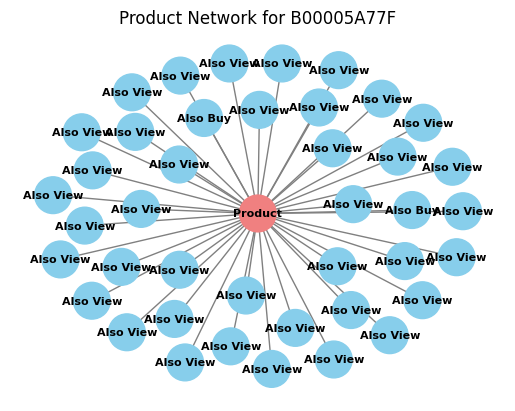

In [ ]:
# Choose one product ASIN for the visualization
selected_product_asin = 'B00005A77F'

# Create a graph
G = nx.Graph()

# Add nodes for the selected product, 'also_view,' and 'also_buy'
G.add_node(selected_product_asin, label='Product')

# Extract 'also_view' and 'also_buy' lists for the selected product
also_view_list = df[df['asin'] == selected_product_asin]['also_view'].iloc[0]
also_buy_list = df[df['asin'] == selected_product_asin]['also_buy'].iloc[0]

# Add nodes for 'also_view' and 'also_buy'
G.add_nodes_from(also_view_list, label='Also View')
G.add_nodes_from(also_buy_list, label='Also Buy')

# Add edges between the selected product and 'also_view' and 'also_buy'
G.add_edges_from([(selected_product_asin, also_view) for also_view in also_view_list])
G.add_edges_from([(selected_product_asin, also_buy) for also_buy in also_buy_list])

node_colors = ['skyblue' if node in also_view_list else 'lightcoral' for node in G.nodes]

# Create a Matplotlib figure and axis
fig, ax = plt.subplots()

# Draw the network plot with different colors for 'also_view' and 'also_buy'
pos = nx.spring_layout(G)  # You can choose other layout options based on your preference
labels = nx.get_node_attributes(G, 'label')
nx.draw(G, pos, with_labels=True, labels=labels, font_size=8, node_size=700, font_color='black', font_weight='bold', node_color=node_colors, edge_color='gray', ax=ax)
plt.title(f'Product Network for {selected_product_asin}')
plt.show()

In [ ]:
unique_categories = df['Category'].unique()
print(unique_categories)


['Hand Care: Creams, Lotions , Cleansers & Gloves'
 'Oral Care: Mouthwashes & Toothpaste' 'Body Care: Lotions & Mists'
 'Personal Care: Perfumes & Deodrants' 'Hair Care: Styling Tools'
 'Face Care: Moisturizers & Creams ' 'Nail Care: Color Polishes '
 'Hair Care: Shampoos' 'Hair Care: Gels & Pomades'
 'Makeup: Foundations & CC Creams' 'Lip Care: Lip Liners'
 'Eye Care: Eye Shadows' 'Face Care: Masks & Peels'
 'Skin Care: Sunscreens' 'Makeup: Powders & Bronzers'
 'Face Care: Serums, Mists & Toners' 'Eye Care: Mascara'
 'Eye Care: Tools & Accessories' 'Makeup: Remover Oils & Balms'
 'Face Care: Cleansers' 'Hair Care: Spray & Mousse'
 'Hair Care: Conditioners' 'Makeup: Blush, Highlighters & Shimmers'
 'Baby Care: Cleansers, Creams & Lotions'
 'Preganancy Care: Cleansers, Creams & Lotions' 'Hair Care: Oils & Serums'
 'Personal Care: Shaving Creams, Lotions & Gels '
 'Personal Care: Home Fragrances' 'Body Care: Cleansers'
 'Face Care: Scrubs' 'Hair Care: Hair Dye'
 'Eye Care: Brow Gels, Ser

In [ ]:
category_counts = df['Category'].value_counts()
print(category_counts)


Personal Care: Perfumes & Deodrants             363
Hair Care: Shampoos                             309
Face Care: Serums, Mists & Toners               292
Hair Care: Conditioners                         276
Face Care: Moisturizers & Creams                270
                                               ... 
Nail Care: Base Coat                             10
Personal Care: Water Bottles                      9
Nail Care: Tools & Accessories                    9
Preganancy Care: Cleansers, Creams & Lotions      8
Lip Care: Lip Liners                              8
Name: Category, Length: 61, dtype: int64


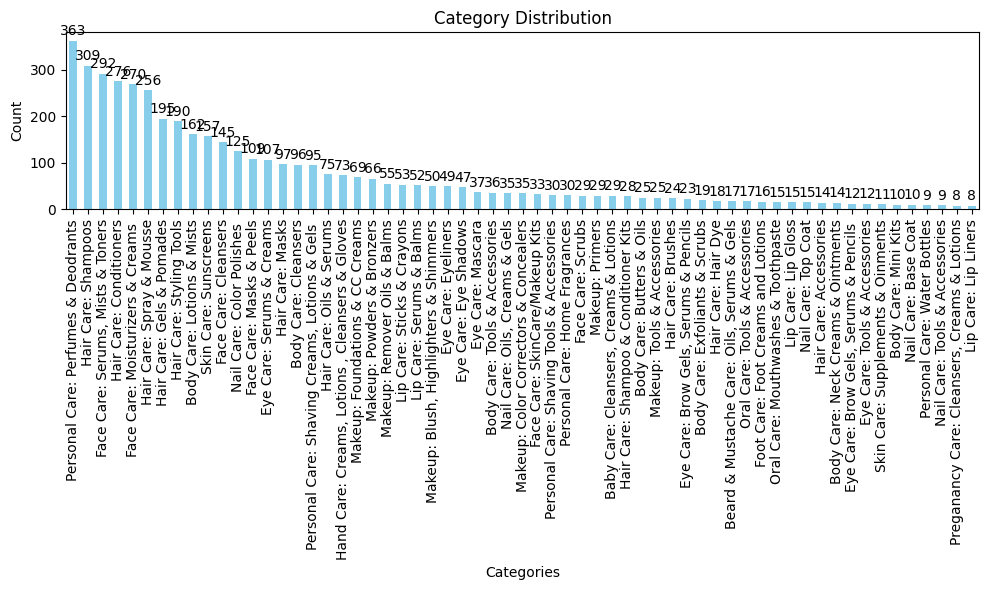

In [ ]:

# Assuming category_counts is already calculated as df['Category'].value_counts()
category_counts = df['Category'].value_counts()

# Plotting the bar chart
plt.figure(figsize=(10, 6))  # You can adjust the figure size as needed
category_counts.plot(kind='bar', color='skyblue')

# Adding labels and title
plt.xlabel('Categories')
plt.ylabel('Count')
plt.title('Category Distribution')

# Adding the count values on top of the bars
for i, count in enumerate(category_counts):
    plt.text(i, count + 5, str(count), ha='center', va='bottom')

# Display the plot
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()


# NLP TASKS

# 1. NLP Task: Text Cleaning

In [ ]:
# Remove duplicates
df.drop_duplicates(inplace=True)

# Remove rows with missing values in relevant columns
df.dropna(subset=['Summary', 'Category'], inplace=True)

# Remove any special characters from the 'summary' column
df['summary_cleaned'] = df['Summary'].str.replace('[^a-zA-Z\s]', '', regex=True)
df['description_cleaned'] = df['description'].str.replace('[^a-zA-Z\s]', '', regex=True)
# Print the count of features
print("Count of Features After Data Cleaning:")
print(df.shape)
column_counts = df.count()
print("\nCounts of Each Column:")
print(column_counts)

Count of Features After Data Cleaning:
(4530, 12)

Counts of Each Column:
asin                   4530
title                  4530
description            4530
also_view              4530
also_buy               4530
price                  4530
imageURLHighRes        4530
overall                4530
Category               4530
Summary                4530
summary_cleaned        4530
description_cleaned    4530
dtype: int64



## 2. NLP Task: Implementing Tokenization, Stop Words Removal and Lemmatization



In [ ]:
# Download the nltk data (if not already downloaded)
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

# Lemmatization function
def lemmatize_text(tokens):
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]
    return lemmatized_tokens

# Tokenization function
def tokenize_text(text):
    # Tokenize the text
    tokens = word_tokenize(text)

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [token.lower() for token in tokens if token.isalpha() and token.lower() not in stop_words]

    return tokens

# Apply tokenization to the 'Summary' column
df['summary_tokens'] = df['summary_cleaned'].apply(tokenize_text)

# Apply lemmatization to the tokenized column
df['summary_lemmatized'] = df['summary_tokens'].apply(lemmatize_text)

# Display the DataFrame with the tokenized and lemmatized columns
print(df[['summary_cleaned', 'summary_tokens', 'summary_lemmatized']])

print(df.columns)

df.to_csv("Cleaned_Products_Data.csv")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


                                        summary_cleaned  \
0     Crabtree amp Evelyn  Gardeners UltraMoisturisi...   
1     Crabtree amp Evelyn Hand Soap Gardeners  fl oz...   
2     Soy Milk Hand Crme Remember why you love your ...   
3     Supersmile Powdered Mouthrinse PSTRONGPlease n...   
4     Supersmile Professional Teeth Whitening Toothp...   
...                                                 ...   
4525  COSMEDIX Simply Brilliant  Brightening Treatme...   
4526  COSMEDIX Phytoharmony Balancing Moisturizer  O...   
4527  COSMEDIX Benefit Balance Antioxidant Infused T...   
4528  ELEMIS Frangipani Monoi Hand Cream and Nail Cr...   
4529  Klorane Conditioner with Pomegranate  ColorTre...   

                                         summary_tokens  \
0     [crabtree, amp, evelyn, gardeners, ultramoistu...   
1     [crabtree, amp, evelyn, hand, soap, gardeners,...   
2     [soy, milk, hand, crme, remember, love, favori...   
3     [supersmile, powdered, mouthrinse, pstrongplea...

# Recommendation System

Select a Product for Recommendation

In [ ]:
selected_asin = 'B00005A77F'
selected_product = df[df['asin'] == selected_asin]

# Extract relevant information for the recommendation system
selected_category = selected_product['Category'].values[0]
selected_summary = selected_product['Summary'].values[0]

print('Selected Product : ', selected_asin)
print('Selected Product Category: ', selected_category)
print('Selected Product Summary: ', selected_summary)

Selected Product :  B00005A77F
Selected Product Category:  Hand Care: Creams, Lotions , Cleansers & Gloves
Selected Product Summary:  Crabtree &amp; Evelyn Hand Soap, Gardeners, 10.1 fl. oz. ['This liquid soap with convenient pump dispenser is formulated with conditioning extracts of sage, rosemary, alfalfa, carrot, and cucumber. It deodorizes the skin and leaves it refreshed with a clean, herbal scent.', "You've watched your favorite gardeners spend hours lovingly pampering their plants, doting all weekend on tulips or carrots or tomatoes, but when was the last time they doted on themselves? Crabtree &amp; Evelyn comes to the rescue of gardeners' hands everywhere with their line of lavish skin-care products. Their hand soap is made from a vegetable-base blend and features sage, alfalfa, and cucumber extracts. It's packaged in a handy metal pump dispenser, and has been formulated to be gentle on a gardener's hands for pampering after a long day in the dirt. Combine this with other Crab

In [ ]:
df.head()

,asin,title,description,also_view,also_buy,price,imageURLHighRes,overall,Category,Summary,summary_cleaned,description_cleaned,summary_tokens,summary_lemmatized
0,B00004U9V2,Crabtree &amp; Evelyn - Gardener's Ultra-Moist...,['After a long day of handling thorny situatio...,"['B00FRERO7G', 'B00GHX7H0A', 'B07GFHJRMX', 'B0...","['B00GHX7H0A', 'B00FRERO7G', 'B00R68QXCS', 'B0...",$30.00,['https://images-na.ssl-images-amazon.com/imag...,5.0,"Hand Care: Creams, Lotions , Cleansers & Gloves",Crabtree &amp; Evelyn - Gardener's Ultra-Moist...,Crabtree amp Evelyn Gardeners UltraMoisturisi...,After a long day of handling thorny situations...,"[crabtree, amp, evelyn, gardeners, ultramoistu...","[crabtree, amp, evelyn, gardener, ultramoistur..."
1,B00005A77F,"Crabtree &amp; Evelyn Hand Soap, Gardeners, 10...",['This liquid soap with convenient pump dispen...,"['B00004U9V2', 'B00GHX7H0A', 'B00FRERO7G', 'B0...",[],$15.99,['https://images-na.ssl-images-amazon.com/imag...,5.0,"Hand Care: Creams, Lotions , Cleansers & Gloves","Crabtree &amp; Evelyn Hand Soap, Gardeners, 10...",Crabtree amp Evelyn Hand Soap Gardeners fl oz...,This liquid soap with convenient pump dispense...,"[crabtree, amp, evelyn, hand, soap, gardeners,...","[crabtree, amp, evelyn, hand, soap, gardener, ..."
2,B00005NDTD,Soy Milk Hand Crme,"[""Remember why you love your favorite blanket?...",[],"['B000NZT6KM', 'B001BY229Q', 'B008J724QY', 'B0...",$18.00,['https://images-na.ssl-images-amazon.com/imag...,5.0,"Hand Care: Creams, Lotions , Cleansers & Gloves","Soy Milk Hand Crme [""Remember why you love you...",Soy Milk Hand Crme Remember why you love your ...,Remember why you love your favorite blanket Th...,"[soy, milk, hand, crme, remember, love, favori...","[soy, milk, hand, crme, remember, love, favori..."
3,B00005V50C,Supersmile Powdered Mouthrinse,['<P><STRONG>Please note: Due to product impro...,"['B07CHTPD6W', 'B07D72B2VX', 'B07CLR4T96', 'B0...","['B0010Y3M2S', 'B00005V50B', 'B00NNZWXEK', 'B0...",$21.73,['https://images-na.ssl-images-amazon.com/imag...,3.0,Oral Care: Mouthwashes & Toothpaste,Supersmile Powdered Mouthrinse ['<P><STRONG>Pl...,Supersmile Powdered Mouthrinse PSTRONGPlease n...,PSTRONGPlease note Due to product improvements...,"[supersmile, powdered, mouthrinse, pstrongplea...","[supersmile, powdered, mouthrinse, pstrongplea..."
4,B00005V50B,Supersmile Professional Teeth Whitening Toothp...,"['Created by Dr. Irwin Smigel, world-renowned ...","['B00TZJDY4Q', 'B07CHTPD6W', 'B076GZSV93', 'B0...","['B00NNZWXEK', 'B0057MMSWY', 'B00TZJDY4Q', 'B0...",$23.00,['https://images-na.ssl-images-amazon.com/imag...,2.0,Oral Care: Mouthwashes & Toothpaste,Supersmile Professional Teeth Whitening Toothp...,Supersmile Professional Teeth Whitening Toothp...,Created by Dr Irwin Smigel worldrenowned Fathe...,"[supersmile, professional, teeth, whitening, t...","[supersmile, professional, teeth, whitening, t..."


Filter products that are also_buy and also_view ed from the selected producta nd same category

In [ ]:
# Convert string representation of lists to actual lists
also_buy_list = ast.literal_eval(selected_product['also_buy'].values[0])
also_view_list = ast.literal_eval(selected_product['also_view'].values[0])

# Filter the DataFrame based on the selected product
filtered_products = df[(df['Category'] == selected_category) &
                       ((df['asin'].isin(also_buy_list)) |
                        (df['asin'].isin(also_view_list)) |
                        (df['asin'] == selected_asin))]
filtered_products.head()


,asin,title,description,also_view,also_buy,price,imageURLHighRes,overall,Category,Summary,summary_cleaned,description_cleaned,summary_tokens,summary_lemmatized
0,B00004U9V2,Crabtree &amp; Evelyn - Gardener's Ultra-Moist...,['After a long day of handling thorny situatio...,"['B00FRERO7G', 'B00GHX7H0A', 'B07GFHJRMX', 'B0...","['B00GHX7H0A', 'B00FRERO7G', 'B00R68QXCS', 'B0...",$30.00,['https://images-na.ssl-images-amazon.com/imag...,5.0,"Hand Care: Creams, Lotions , Cleansers & Gloves",Crabtree &amp; Evelyn - Gardener's Ultra-Moist...,Crabtree amp Evelyn Gardeners UltraMoisturisi...,After a long day of handling thorny situations...,"[crabtree, amp, evelyn, gardeners, ultramoistu...","[crabtree, amp, evelyn, gardener, ultramoistur..."
1,B00005A77F,"Crabtree &amp; Evelyn Hand Soap, Gardeners, 10...",['This liquid soap with convenient pump dispen...,"['B00004U9V2', 'B00GHX7H0A', 'B00FRERO7G', 'B0...",[],$15.99,['https://images-na.ssl-images-amazon.com/imag...,5.0,"Hand Care: Creams, Lotions , Cleansers & Gloves","Crabtree &amp; Evelyn Hand Soap, Gardeners, 10...",Crabtree amp Evelyn Hand Soap Gardeners fl oz...,This liquid soap with convenient pump dispense...,"[crabtree, amp, evelyn, hand, soap, gardeners,...","[crabtree, amp, evelyn, hand, soap, gardener, ..."
2088,B00FRERO7G,Crabtree &amp; Evelyn Gardeners Ultra-Moisturi...,"[""Lock in lashings of moisture with our award-...","['B00004U9V2', 'B00GHX7H0A', 'B00TJ3NBN2', 'B0...","['B00004U9V2', 'B000Z65AZE', 'B00GHX7H0A', 'B0...",$24.00,['https://images-na.ssl-images-amazon.com/imag...,5.0,"Hand Care: Creams, Lotions , Cleansers & Gloves",Crabtree &amp; Evelyn Gardeners Ultra-Moisturi...,Crabtree amp Evelyn Gardeners UltraMoisturisin...,Lock in lashings of moisture with our awardwin...,"[crabtree, amp, evelyn, gardeners, ultramoistu...","[crabtree, amp, evelyn, gardener, ultramoistur..."
2138,B00GHX58LK,Crabtree &amp; Evelyn Ultra-Moisturising Hand ...,"[""Lock in lashings of moisture with our Evelyn...","['B00GHXE4N8', 'B00GHX52MK', 'B00R68QXJG', 'B0...","['B00R68QXJG', 'B00A8SNGK0', 'B00025WYZC', 'B0...",$20.00,['https://images-na.ssl-images-amazon.com/imag...,4.0,"Hand Care: Creams, Lotions , Cleansers & Gloves",Crabtree &amp; Evelyn Ultra-Moisturising Hand ...,Crabtree amp Evelyn UltraMoisturising Hand Cre...,Lock in lashings of moisture with our Evelyn R...,"[crabtree, amp, evelyn, ultramoisturising, han...","[crabtree, amp, evelyn, ultramoisturising, han..."
2355,B00K1C6D3A,"Crabtree &amp; Evelyn Hand Wash, Caribbean Isl...","[""Leave hands feeling soft and conditioned wit...","['B01N418YRR', 'B00K1C8V1W', 'B074KDPT25', 'B0...","['B00KC8TPVA', 'B074KHCPLG', 'B00K1C8V1W', 'B0...",$18.00,['https://images-na.ssl-images-amazon.com/imag...,5.0,"Hand Care: Creams, Lotions , Cleansers & Gloves","Crabtree &amp; Evelyn Hand Wash, Caribbean Isl...",Crabtree amp Evelyn Hand Wash Caribbean Island...,Leave hands feeling soft and conditioned with ...,"[crabtree, amp, evelyn, hand, wash, caribbean,...","[crabtree, amp, evelyn, hand, wash, caribbean,..."


In [ ]:
filtered_products.shape

(8, 14)

# 3. NLP Task: Implementing Text Vectorization

In [ ]:
# Apply lemmatization to the tokenized column
filtered_products['summary_lemmatized'] = filtered_products['summary_tokens'].apply(lemmatize_text)

# Convert the lemmatized tokens back to text
filtered_products['summary_lemmatized_text'] = filtered_products['summary_lemmatized'].apply(' '.join)

# Apply TF-IDF vectorization
tfidf_vectorizer = TfidfVectorizer()
X = tfidf_vectorizer.fit_transform(filtered_products['summary_lemmatized_text'])

# Create a DataFrame from the TF-IDF matrix
tfidf_df = pd.DataFrame(X.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

# Display the DataFrame with TF-IDF values
print(tfidf_df)

     accent  accessory    accord      acid       act     added       air  \
0  0.000000   0.000000  0.000000  0.081390  0.000000  0.000000  0.000000   
1  0.000000   0.069208  0.000000  0.000000  0.000000  0.000000  0.000000   
2  0.000000   0.000000  0.000000  0.083696  0.000000  0.000000  0.000000   
3  0.076992   0.000000  0.055680  0.000000  0.000000  0.064526  0.000000   
4  0.000000   0.000000  0.058866  0.000000  0.081397  0.000000  0.136435   
5  0.000000   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
6  0.000000   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
7  0.000000   0.000000  0.065677  0.000000  0.000000  0.076110  0.076110   

    alfalfa      aloe      also  ...     whose      wild      work   working  \
0  0.000000  0.000000  0.000000  ...  0.038783  0.000000  0.070233  0.000000   
1  0.116003  0.050051  0.000000  ...  0.027638  0.000000  0.000000  0.000000   
2  0.000000  0.000000  0.000000  ...  0.039882  0.000000  0.072223  0.00000

<ipython-input-17-689aac837de9>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_products['summary_lemmatized'] = filtered_products['summary_tokens'].apply(lemmatize_text)
<ipython-input-17-689aac837de9>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_products['summary_lemmatized_text'] = filtered_products['summary_lemmatized'].apply(' '.join)


# Use Knn for selecting most similar K products

In [ ]:
knn = NearestNeighbors(n_neighbors=5, metric='cosine')
knn.fit(tfidf_df)

NearestNeighbors(metric='cosine')

In [ ]:

# Get the index of the selected product in the filtered products
selected_index = filtered_products[filtered_products['asin'] == selected_asin].index[0]

# Find the indices of the nearest neighbors
distances, neighbor_indices = knn.kneighbors(tfidf_df.iloc[[selected_index]])

# Exclude the selected product itself
neighbor_indices = neighbor_indices[0][1:]

# Retrieve the ASINs of the nearest neighbors
nearest_neighbor_asins = filtered_products.iloc[neighbor_indices]['asin'].tolist()


sort w.r.t overall befor presenting top 5 recommendations

In [ ]:
# Sort nearest neighbors based on the 'overall' column
nearest_neighbors_sorted = filtered_products.iloc[neighbor_indices].sort_values(by='overall', ascending=False)

# Select the top 5 recommendations
top_recommendations = nearest_neighbors_sorted.head(5)

# Display the top recommendations
print("Selected Product:")
print(selected_product[['asin', 'title', 'overall']])
print()
print("Top 5 Recommendations:")
print(top_recommendations[['asin', 'title', 'overall']])


Selected Product:
         asin                                              title  overall
1  B00005A77F  Crabtree &amp; Evelyn Hand Soap, Gardeners, 10...      5.0

Top 5 Recommendations:
            asin                                              title  overall
2654  B00R68QXCS  Crabtree &amp; Evelyn Hand Soap, Gardeners, 16...      5.0
0     B00004U9V2  Crabtree &amp; Evelyn - Gardener's Ultra-Moist...      5.0
2088  B00FRERO7G  Crabtree &amp; Evelyn Gardeners Ultra-Moisturi...      5.0
2381  B00KOBT82G  Crabtree &amp; Evelyn, Gardeners Mini 60 Secon...      5.0


In [ ]:
df = pd.read_csv('Cleaned_Products_Data.csv')
df.head()

,Unnamed: 0,asin,title,description,also_view,also_buy,price,imageURLHighRes,overall,Category,Summary,summary_cleaned,description_cleaned,summary_tokens,summary_lemmatized
0,0,B00004U9V2,Crabtree &amp; Evelyn - Gardener's Ultra-Moist...,['After a long day of handling thorny situatio...,"['B00FRERO7G', 'B00GHX7H0A', 'B07GFHJRMX', 'B0...","['B00GHX7H0A', 'B00FRERO7G', 'B00R68QXCS', 'B0...",$30.00,['https://images-na.ssl-images-amazon.com/imag...,5.0,"Hand Care: Creams, Lotions , Cleansers & Gloves",Crabtree &amp; Evelyn - Gardener's Ultra-Moist...,Crabtree amp Evelyn Gardeners UltraMoisturisi...,After a long day of handling thorny situations...,"['crabtree', 'amp', 'evelyn', 'gardeners', 'ul...","['crabtree', 'amp', 'evelyn', 'gardener', 'ult..."
1,1,B00005A77F,"Crabtree &amp; Evelyn Hand Soap, Gardeners, 10...",['This liquid soap with convenient pump dispen...,"['B00004U9V2', 'B00GHX7H0A', 'B00FRERO7G', 'B0...",[],$15.99,['https://images-na.ssl-images-amazon.com/imag...,5.0,"Hand Care: Creams, Lotions , Cleansers & Gloves","Crabtree &amp; Evelyn Hand Soap, Gardeners, 10...",Crabtree amp Evelyn Hand Soap Gardeners fl oz...,This liquid soap with convenient pump dispense...,"['crabtree', 'amp', 'evelyn', 'hand', 'soap', ...","['crabtree', 'amp', 'evelyn', 'hand', 'soap', ..."
2,2,B00005NDTD,Soy Milk Hand Crme,"[""Remember why you love your favorite blanket?...",[],"['B000NZT6KM', 'B001BY229Q', 'B008J724QY', 'B0...",$18.00,['https://images-na.ssl-images-amazon.com/imag...,5.0,"Hand Care: Creams, Lotions , Cleansers & Gloves","Soy Milk Hand Crme [""Remember why you love you...",Soy Milk Hand Crme Remember why you love your ...,Remember why you love your favorite blanket Th...,"['soy', 'milk', 'hand', 'crme', 'remember', 'l...","['soy', 'milk', 'hand', 'crme', 'remember', 'l..."
3,3,B00005V50C,Supersmile Powdered Mouthrinse,['<P><STRONG>Please note: Due to product impro...,"['B07CHTPD6W', 'B07D72B2VX', 'B07CLR4T96', 'B0...","['B0010Y3M2S', 'B00005V50B', 'B00NNZWXEK', 'B0...",$21.73,['https://images-na.ssl-images-amazon.com/imag...,3.0,Oral Care: Mouthwashes & Toothpaste,Supersmile Powdered Mouthrinse ['<P><STRONG>Pl...,Supersmile Powdered Mouthrinse PSTRONGPlease n...,PSTRONGPlease note Due to product improvements...,"['supersmile', 'powdered', 'mouthrinse', 'pstr...","['supersmile', 'powdered', 'mouthrinse', 'pstr..."
4,4,B00005V50B,Supersmile Professional Teeth Whitening Toothp...,"['Created by Dr. Irwin Smigel, world-renowned ...","['B00TZJDY4Q', 'B07CHTPD6W', 'B076GZSV93', 'B0...","['B00NNZWXEK', 'B0057MMSWY', 'B00TZJDY4Q', 'B0...",$23.00,['https://images-na.ssl-images-amazon.com/imag...,2.0,Oral Care: Mouthwashes & Toothpaste,Supersmile Professional Teeth Whitening Toothp...,Supersmile Professional Teeth Whitening Toothp...,Created by Dr Irwin Smigel worldrenowned Fathe...,"['supersmile', 'professional', 'teeth', 'white...","['supersmile', 'professional', 'teeth', 'white..."


In [ ]:
joblib.dump(tfidf_vectorizer, 'balanced_tfidf_vectorizer.pkl')

['balanced_tfidf_vectorizer.pkl']

In [ ]:
for encoding in encodings_to_try:
    try:
        df = pd.read_csv('Product_also_buy_view.csv', encoding=encoding)
        # If reading is successful, break out of the loop
        break
    except UnicodeDecodeError:
        continue

# Remove duplicates
df.drop_duplicates(inplace=True)

# Remove rows with missing values in relevant columns
df.dropna(subset=['Summary', 'Category'], inplace=True)

# Remove any special characters from the 'summary' column
df['summary_cleaned'] = df['Summary'].str.replace('[^a-zA-Z\s]', '', regex=True)
df['description_cleaned'] = df['description'].str.replace('[^a-zA-Z\s]', '', regex=True)

df.to_csv('cleaned_final_product.csv')

In [ ]:
df.head()

,asin,title,description,also_view,also_buy,price,imageURLHighRes,overall,Category,Summary,summary_cleaned,description_cleaned
0,B00004U9V2,Crabtree &amp; Evelyn - Gardener's Ultra-Moist...,['After a long day of handling thorny situatio...,"['B00FRERO7G', 'B00GHX7H0A', 'B07GFHJRMX', 'B0...","['B00GHX7H0A', 'B00FRERO7G', 'B00R68QXCS', 'B0...",$30.00,['https://images-na.ssl-images-amazon.com/imag...,5.0,"Hand Care: Creams, Lotions , Cleansers & Gloves",Crabtree &amp; Evelyn - Gardener's Ultra-Moist...,Crabtree amp Evelyn Gardeners UltraMoisturisi...,After a long day of handling thorny situations...
1,B00005A77F,"Crabtree &amp; Evelyn Hand Soap, Gardeners, 10...",['This liquid soap with convenient pump dispen...,"['B00004U9V2', 'B00GHX7H0A', 'B00FRERO7G', 'B0...",[],$15.99,['https://images-na.ssl-images-amazon.com/imag...,5.0,"Hand Care: Creams, Lotions , Cleansers & Gloves","Crabtree &amp; Evelyn Hand Soap, Gardeners, 10...",Crabtree amp Evelyn Hand Soap Gardeners fl oz...,This liquid soap with convenient pump dispense...
2,B00005NDTD,Soy Milk Hand Crme,"[""Remember why you love your favorite blanket?...",[],"['B000NZT6KM', 'B001BY229Q', 'B008J724QY', 'B0...",$18.00,['https://images-na.ssl-images-amazon.com/imag...,5.0,"Hand Care: Creams, Lotions , Cleansers & Gloves","Soy Milk Hand Crme [""Remember why you love you...",Soy Milk Hand Crme Remember why you love your ...,Remember why you love your favorite blanket Th...
3,B00005V50C,Supersmile Powdered Mouthrinse,['<P><STRONG>Please note: Due to product impro...,"['B07CHTPD6W', 'B07D72B2VX', 'B07CLR4T96', 'B0...","['B0010Y3M2S', 'B00005V50B', 'B00NNZWXEK', 'B0...",$21.73,['https://images-na.ssl-images-amazon.com/imag...,3.0,Oral Care: Mouthwashes & Toothpaste,Supersmile Powdered Mouthrinse ['<P><STRONG>Pl...,Supersmile Powdered Mouthrinse PSTRONGPlease n...,PSTRONGPlease note Due to product improvements...
4,B00005V50B,Supersmile Professional Teeth Whitening Toothp...,"['Created by Dr. Irwin Smigel, world-renowned ...","['B00TZJDY4Q', 'B07CHTPD6W', 'B076GZSV93', 'B0...","['B00NNZWXEK', 'B0057MMSWY', 'B00TZJDY4Q', 'B0...",$23.00,['https://images-na.ssl-images-amazon.com/imag...,2.0,Oral Care: Mouthwashes & Toothpaste,Supersmile Professional Teeth Whitening Toothp...,Supersmile Professional Teeth Whitening Toothp...,Created by Dr Irwin Smigel worldrenowned Fathe...


# Recommendation Engine for People also Bought

In [ ]:
encodings_to_try = ['utf-8', 'ISO-8859-1', 'latin1']

# Try reading the CSV file with different encodings

for encoding in encodings_to_try:
    try:
        df = pd.read_csv('cleaned_final_product.csv', encoding=encoding)
        # If reading is successful, break out of the loop
        break
    except UnicodeDecodeError:
        continue

# Download the nltk data (if not already downloaded)
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

# Lemmatization function
def lemmatize_text(tokens):
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]
    return lemmatized_tokens

# Tokenization function
def tokenize_text(text):
    # Tokenize the text
    tokens = word_tokenize(text)

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [token.lower() for token in tokens if token.isalpha() and token.lower() not in stop_words]

    return tokens

# Apply tokenization to the 'Summary' column
df['summary_tokens'] = df['summary_cleaned'].apply(tokenize_text)

# Apply lemmatization to the tokenized column
df['summary_lemmatized'] = df['summary_tokens'].apply(lemmatize_text)


df.to_csv("Cleaned_Products_Data.csv")
# Select a product
query = input("Select a Product: ")

selected_asin = query
selected_product = df[df['asin'] == selected_asin]

# Extract relevant information for the recommendation system
selected_category = selected_product['Category'].values[0]
selected_summary = selected_product['Summary'].values[0]

# Convert string representation of lists to actual lists
also_buy_list = ast.literal_eval(selected_product['also_buy'].values[0])
also_view_list = ast.literal_eval(selected_product['also_view'].values[0])

# Filter the DataFrame based on the selected product
filtered_products = df[((df['asin'].isin(also_buy_list)) |
                        (df['asin'].isin(also_view_list)) |
                        (df['asin'] == selected_asin))]

# Apply lemmatization to the tokenized column
filtered_products['summary_lemmatized'] = filtered_products['summary_tokens'].apply(lemmatize_text)

# Convert the lemmatized tokens back to text
filtered_products['summary_lemmatized_text'] = filtered_products['summary_lemmatized'].apply(' '.join)

# Apply TF-IDF vectorization
tfidf_vectorizer = TfidfVectorizer()
X = tfidf_vectorizer.fit_transform(filtered_products['summary_lemmatized_text'])

# Create a DataFrame from the TF-IDF matrix
tfidf_df = pd.DataFrame(X.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

if filtered_products.shape[0] < 10:
    n_neighbors = filtered_products.shape[0]
else:
    n_neighbors = 10  # Set a default value or any other desired value

knn = NearestNeighbors(n_neighbors=n_neighbors, metric='cosine')
knn.fit(tfidf_df)

# Get the index of the selected product in the filtered products
selected_index = filtered_products[filtered_products['asin'] == selected_asin].index[0]

# Find the indices of the nearest neighbors
distances, neighbor_indices = knn.kneighbors(tfidf_df.iloc[[selected_index]])

# Exclude the selected product itself
neighbor_indices = neighbor_indices[0][1:]

# Retrieve the ASINs of the nearest neighbors
nearest_neighbor_asins = filtered_products.iloc[neighbor_indices]['asin'].tolist()

# Sort nearest neighbors based on the 'overall' column
nearest_neighbors_sorted = filtered_products.iloc[neighbor_indices].sort_values(by='overall', ascending=False)

# Select the top 5 recommendations
top_recommendations = nearest_neighbors_sorted.head(5)

# Display the top recommendations
print(selected_product[['asin', 'title','price']])
print()
print("Top 5 Recommendations:")
print(top_recommendations[['asin', 'title','price']])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Select a Product: B00005A77F
         asin                                              title   price
1  B00005A77F  Crabtree &amp; Evelyn Hand Soap, Gardeners, 10...  $15.99

Top 5 Recommendations:
            asin                                              title   price
2654  B00R68QXCS  Crabtree &amp; Evelyn Hand Soap, Gardeners, 16...  $28.00
0     B00004U9V2  Crabtree &amp; Evelyn - Gardener's Ultra-Moist...  $30.00
2088  B00FRERO7G  Crabtree &amp; Evelyn Gardeners Ultra-Moisturi...  $24.00
2381  B00KOBT82G  Crabtree &amp; Evelyn, Gardeners Mini 60 Secon...  $12.50
2355  B00K1C6D3A  Crabtree &amp; Evelyn Hand Wash, Caribbean Isl...  $18.00


<ipython-input-9-f9705ed71c25>:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_products['summary_lemmatized'] = filtered_products['summary_tokens'].apply(lemmatize_text)
<ipython-input-9-f9705ed71c25>:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_products['summary_lemmatized_text'] = filtered_products['summary_lemmatized'].apply(' '.join)
